In [58]:
import dtale
import chess
import chess.pgn
import chess.svg

import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px


In [3]:
df = pd.read_csv("games.csv")

In [4]:
# Filtering
df1 = df[df["rated"]==True].drop(columns=["rated","white_id","black_id"])

In [5]:
#df1.head()

In [17]:
df1.columns

Index(['id', 'created_at', 'last_move_at', 'turns', 'victory_status', 'winner',
       'increment_code', 'white_rating', 'black_rating', 'moves',
       'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')

In [57]:
%%time

## Parse the moves column into a list of "fens" which are strings that represent the board, the pieces on the board, and their coordinates
.
fens = []
for game in df1["moves"]:
    board = chess.Board()
    for move in game.split():
        board.push(board.parse_san(move))
    fens.append(board.fen())

## Takes about 40 seconds on my end.
## Append this column to the dataframe. 
# df1["endFEN"] = fens

['r1bqk1nr/pppp2pp/8/4n3/1bP1P3/8/PP4PP/RNB1KBNR w KQkq - 1 9', '8/5P2/2P4R/4p3/k1P5/2Q5/1P3PPP/3BK1NR b K - 4 31', '7r/R5Qp/2p3Nk/3pP1p1/8/4P1P1/1P2BP1P/5RK1 b - - 0 31', '6Q1/7R/7k/8/P3p3/5P2/6KP/8 b - - 5 48', '3r1b1r/2Nnkppp/p1Q1p3/8/6q1/8/PPPB2PP/R4RK1 b - - 2 17', '4r1k1/p2Q1ppp/8/2pP4/2P1r3/P3q2P/1P4PK/5n2 w - - 0 34', '8/6Qk/5K2/8/8/7p/7P/8 b - - 18 60', '2r1qrk1/p2p1ppp/1p6/8/1PP1B3/P2Pn1P1/5P1P/R1BQ1RK1 w - - 0 19', 'r1bqkb1r/pp1p1pp1/2n2n1p/4p3/Q3P3/2N1BN2/PPP2PPP/R3KB1R b KQkq - 1 7', '4r1k1/p6Q/2p3P1/1p1p4/3P4/4P3/PPn3P1/5RK1 b - - 1 35', 'r7/pp1k4/b2p1p1p/3R4/4P3/1P3P2/P5PP/R5K1 b - - 0 22', '1r1k3r/2pb1ppp/8/3p4/2q4P/P3pnP1/1KP2P2/R1B5 w - - 4 28', 'rq5k/p5pp/8/3B4/8/5N1P/PP3PP1/R5K1 b - - 0 27', '5k2/7p/3p2p1/Q7/P4q2/2P4P/6P1/5rK1 w - - 0 34', '5rk1/N1n2pbp/6p1/8/8/8/2P3K1/8 w - - 0 33', '5rk1/5p1p/1Q1p2p1/p7/3P4/2p1P3/3q1nPP/6RK w - - 5 33', '4Rbk1/3r1p1p/p5p1/1p1p4/8/B7/PPB2PPP/3R2K1 w - - 1 28', 'rn1q1rk1/ppp1npb1/6Bp/3pN3/3P1Bb1/8/PPP2PPP/RN2K2R b KQ - 0 10', 'r2q1b

In [84]:
# Code in this cell is adapted from https://andreasstckl.medium.com/chessviz-graphs-of-chess-games-7ebd4f85a9b9
# Define a function that coverts the FEN notation into a tensor representation of the board.

def fen_to_tensor(input_str):
    # creates a dictionary of pieces. 1 to 6 is white pieces, -1 to -6 is black pieces.
    pieces_str = "PNBRQKpnbrqk"
    pieces = set(pieces_str)
    pieces_dict = {pieces_str[0]:1, pieces_str[1]:2, pieces_str[2]:3, pieces_str[3]:4 , 
                    pieces_str[4]:5, pieces_str[5]:6,
                    pieces_str[6]:-1, pieces_str[7]:-2, pieces_str[8]:-3, pieces_str[9]:-4, 
                    pieces_str[10]:-5, pieces_str[11]:-6}
    
    # creates a tensor representation of the board. 
    # This tensor represents a 8*8 board for each of the 6 possible pieces.
    # The first two axis are the coordinates, the third axis is whether there is a piece there or not.
    # If 1, there is a white piece there. If -1, there is a black piece there.
    # For example, if the value at position (0,0,0) is 1, then there is a white pawn at the A8 sqr.
    board_tensor = np.zeros((8,8,6))
    input_list = input_str.split()
    rownr = 0
    colnr = 0
    valid_spaces = set(range(1,9))
    
    # As input list is a split FEN, index 0 is the pos of each piece on the board.
    # This loop goes through every element of the FEN which is the same as looking at each square of the board in sequence and seeing what piece is there.
    for i,c in enumerate(input_list[0]):
        if c in pieces:
            board_tensor[rownr,colnr,np.abs(pieces_dict[c])-1] = np.sign(pieces_dict[c])
            colnr = colnr + 1
        elif c == "/": 
            #a backslash means the row is over, so we go to the next row
            rownr += 1
            colnr = 0
        elif int(c) in valid_spaces:
            # a number means that many squares in the row are empty.
            colnr += int(c)
        else:
            raise ValueError("invalid fenstr at index: {} char: {}".format(i, c))
        
    return board_tensor
    
    
# Define other useful functions for these tensors.
# Counts the total amount of pieces on the board.
def count_pieces(fen):
    board_tensor = fen_to_tensor(fen)
    return np.sum(np.abs(board_tensor))

# This outputs a tuple containing the total amt of pawns, knights, bishops, rooks, and queens in the board.
def count_all_pieces(fen):
    board_tensor = fen_to_tensor(fen)
    counts = np.sum(np.abs(board_tensor),axis=(0,1))
    return counts[0],counts[1],counts[2],counts[3],counts[4]

# Define boolean functions that tell us if we have reached a certain type of ending.
def is_pawn_ending(fen):
    board_tensor = fen_to_tensor(fen)
    # the counts function will count occupied squares for any given "piece" matrix.
    # e.g., counts[0] will return the amount of pawns. 
    counts = np.sum(np.abs(board_tensor),axis = (0,1))
    if counts[1]==0 and counts[2]==0 and counts[3]==0 and counts[4]==0:
        return True
    else:
        return False

In [99]:
# Just a test cell to test the understanding of this technique.
fen = chess.Board().fen()
test_fen = fens[0]
# check for pawn at B7, king in E8, king in E1
coords = [(1,1,0),(0,4,5),(7,4,5)] 
for coord in coords:
    print(fen_to_tensor(test_fen)[coord])

-1.0
-1.0
1.0


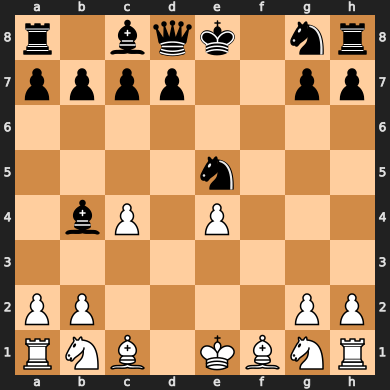

In [97]:
board = chess.Board(test_fen)
chess.svg.board(board)

### Dataset Export

In [13]:
# Export the preprocessed dataset.
df_export = df1.copy()
df_export.to_csv("chess_app.csv")